# Correlators of longitudinal and transverse electric and magnetic fields of the Glasma

Computation of gauge invariant correlators of chromoelectric and chromomagnetic fields. The longitudinal correlation is $\langle FF\rangle_L(r) = \langle \mathrm{Tr} \left\{ F_z(x_T) U_{x \rightarrow y} F_z(y_T) U_{y \rightarrow x} \right\} \rangle$ with $r\equiv x_T-y_T$ and $F\in\{E,B\}$ either the electric or magnetic field, whereas the transvrse one is evaluated as $\langle FF\rangle_{T}(r) = \langle \mathrm{Tr} \left\{ F_x(x_T) U_{x \rightarrow y} F_x(y_T) U_{y \rightarrow x} \right\} \rangle+\langle \mathrm{Tr} \left\{ F_y(x_T) U_{x \rightarrow y} F_y(y_T) U_{y \rightarrow x} \right\} \rangle$.

In [1]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su3"
os.environ["PRECISION"] = "double"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
from curraun.correlators import Correlators
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size':18})

import pickle
from tqdm import tqdm

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

Using CUDA
Using SU(3)
Unknown representation
Using double precision
Using double precision


In [2]:
import numpy as np

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# Simulation box parameters
L = 10      # Length of simulation box [fm]
N = 1024     # Number of lattice sites
DTS = 16     # Time step
NE = 20        # Number of events

# MV model parameters
g2mu = 2.0      # MV model parameter times squared coupling [GeV]
NS = 50     # Number of color sheets
factor = 0.8        # Qs/g2mu ratio from Lappi, for Ns=50 sheets
Qs = factor*g2mu        # Saturation momentum [GeV]
G = np.pi * np.sqrt(1 / np.log(Qs / 0.2))           # Running coupling constant		
MU = g2mu / G**2        # MV model parameter
M = 0.1 * g2mu      # Intrared regulator [GeV]
UV = 10.0           # Ultraviolet regulator [GeV]

# Proper time when correlators are evaluated
taus = [0.01, 0.05, 0.1, 0.15, 0.3]
DT = 1/DTS
ts = np.round(np.multiply(np.array(taus), DTS/L*N)).astype(int)

In [ ]:
# Empty dictionaries of correlators
ETs, BTs = {}, {}
ELs, BLs = {}, {}

for t in ts:
    ETs[str(int(t))], BTs[str(int(t))] = [], []
    ELs[str(int(t))], BLs[str(int(t))] = [], []

with tqdm(total=NE) as pbar:
    for e in range(NE):
        E0 = N / L * hbarc
        s = core.Simulation(N, DT, G)
        va = mv.wilson(s, mu=MU / E0, m=M / E0, uv=UV / E0, num_sheets=NS)
        vb = mv.wilson(s, mu=MU / E0, m=M / E0, uv=UV / E0, num_sheets=NS)
        initial.init(s, va, vb)

        if use_cuda:
            s.copy_to_device()

        for t in range(int(ts[len(ts)-1])+1):
            core.evolve_leapfrog(s)

            if t in ts:
                corr = Correlators(s)
                corr.compute('Ex')
                Ex_c = corr.corr.copy()
                corr.compute('Ey')
                Ey_c = corr.corr.copy()

                ETs[str(int(t))].append(Ex_c+Ey_c)

                corr.compute('Bx')
                Bx_c = corr.corr.copy()
                corr.compute('By')
                By_c = corr.corr.copy()

                BTs[str(int(t))].append(Bx_c+By_c)

                corr.compute('Ez')
                Ez_c = corr.corr.copy()
                ELs[str(int(t))].append(Ez_c)

                corr.compute('Bz')
                Bz_c = corr.corr.copy()
                BLs[str(int(t))].append(Bz_c)
        
        pbar.set_description('Event {} of {}'.format(e+1, NE))
        pbar.update(1)

ET_avg, BT_avg = {},{}
EL_avg, BL_avg = {},{}

for t in ts:
    ET_avg[str(int(t))] = np.mean(np.array(ETs[str(int(t))]), axis=0)
    BT_avg[str(int(t))] = np.mean(np.array(BTs[str(int(t))]), axis=0)

    EL_avg[str(int(t))] = np.mean(np.array(ELs[str(int(t))]), axis=0)
    BL_avg[str(int(t))] = np.mean(np.array(BLs[str(int(t))]), axis=0)

res = {}
res["ET"], res["BT"] = ET_avg, BT_avg
res["EL"], res["BL"] = EL_avg, BL_avg
res["ts"], res["taus"] = ts, taus

r = np.linspace(0, L/2, num=N//2) 
res["r"], res["Qs"] = r, Qs
res["E0"], res["G"], res["hbarc"] = E0, G, hbarc

fname = "trans_long_correlators.pickle"
pickle.dump(res, open(fname, "wb"))

## Load data from files

In [1]:
# load the data
import numpy as np
import matplotlib.pyplot as plt
import pickle

fname = "trans_long_correlators.pickle"
res = pickle.load(open(fname, "rb"))

## Coordinate space correlators

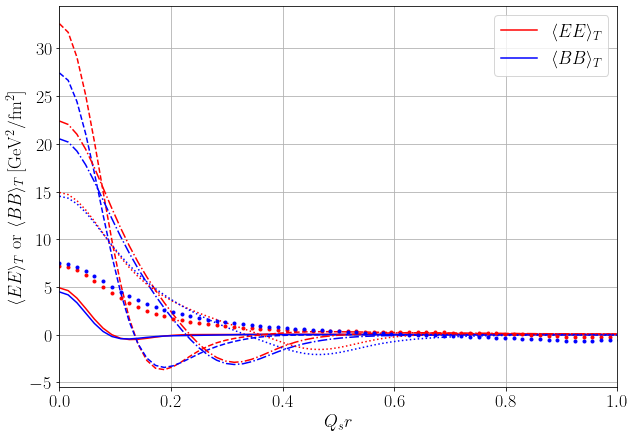

In [7]:
r = np.linspace(0, L/2, num=N//2) 
formats = ['-', '--', '-.', ':', '.']

for i,t in enumerate(res["ts"]):
    E0 = N / L * hbarc
    Exs, Bxs = res["ET"][str(int(t))], res["BT"][str(int(t))]
    
    f = E0 ** 4 / hbarc**2 / G ** 2
    plt.plot(Qs*r, Exs*f, formats[i], c='r')
    plt.plot(Qs*r, Bxs*f, formats[i], c='b')

plt.xlim([0, 1.0])
plt.grid()
plt.xlabel(r"$Q_s r$")
plt.ylabel(r"$\langle EE\rangle_T\,\,\mathrm{or}\,\,\langle BB\rangle_T\,\mathrm{[GeV^2/fm^2]}$")
plt.legend([r"$\langle EE\rangle_T$", r"$\langle BB\rangle_T$"])
plt.show()

In [2]:
using Pickle

res = Pickle.npyload("trans_long_correlators.pickle")

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

string_as_varname (generic function with 1 method)

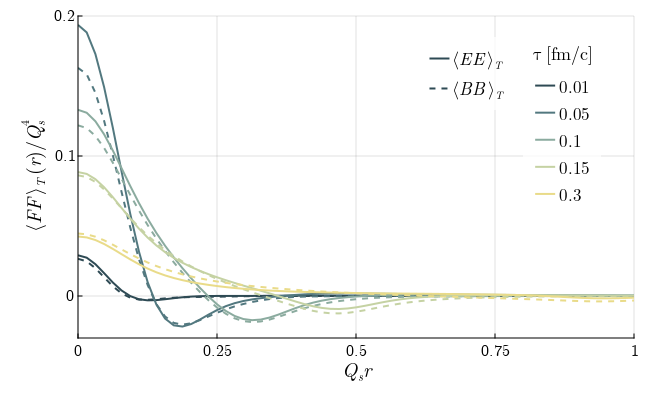

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000cc4bf30, 3250.0, 2000.0)


In [16]:
using CairoMakie
using Interpolations
using ColorSchemes

starrynight = cgrad(:starrynight, 24, categorical = true)
colors = [starrynight[4], starrynight[8], starrynight[12], starrynight[16], starrynight[20]]

fig = Figure(resolution = (650, 400), font = "CMU Serif")
ax = Axis(fig[1,1], xlabel=L"Q_s r", ylabel=L"\langle FF\,\rangle_T\,(r)/Q_s^4",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=16, yticklabelsize=16,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5) 

units = res["E0"]^4/res["G"]^2
for (i, t) in enumerate(res["ts"])
        string_as_varname("line_el_"*string(i), lines!(ax, res["r"].*res["Qs"], res["ET"][string(t)].*units./res["Qs"]^4, linewidth = 2, color=colors[i]))
        string_as_varname("line_mag_"*string(i),lines!(ax, res["r"].*res["Qs"], res["BT"][string(t)].*units./res["Qs"]^4, linestyle="-", linewidth = 2, color=colors[i]))
end

xlims!(ax, 0, 1)
ylims!(ax, -0.03, 0.2)
ax.xticks = (0.25*(0:4), ["0", "0.25", "0.5", "0.75", "1"])
ax.yticks = (0.1*(0:2), ["0", "0.1", "0.2"])


axislegend(ax, [line_el_1, line_mag_1], [L"\langle EE\,\rangle_T", L"\langle BB\,\rangle_T"],  labelsize=18, 
    position = (0.75, 0.95), bgcolor = (:white, 0.7), framecolor = (:white, 0))
axislegend(ax, [line_el_1, line_el_2, line_el_3, line_el_4, line_el_5], 
    [L"0.01", L"0.05", L"0.1", L"0.15", L"0.3"], L"\tau\,\mathrm{[fm/c]}", titlesize=18,
    labelsize=17, position = (0.95,0.95),  bgcolor = (:white, 0.7), framecolor = (:white, 0))

display(fig)

save("corr_FF_T.png", fig, px_per_unit = 5.0) 

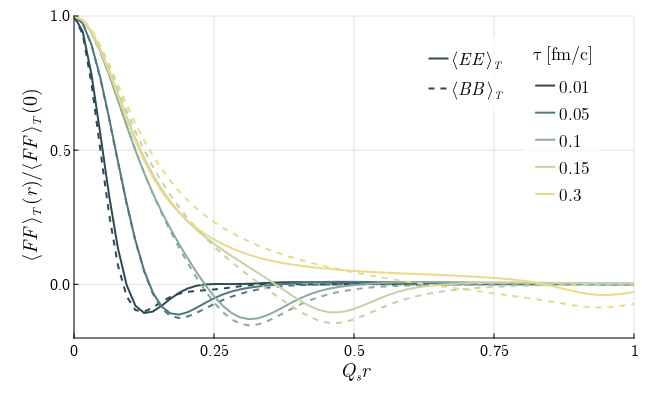

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000ceaff60, 3250.0, 2000.0)


In [30]:
using CairoMakie
using Interpolations
using ColorSchemes

starrynight = cgrad(:starrynight, 24, categorical = true)
colors = [starrynight[4], starrynight[8], starrynight[12], starrynight[16], starrynight[20]]

fig = Figure(resolution = (650, 400), font = "CMU Serif")
ax = Axis(fig[1,1], xlabel=L"Q_s r", ylabel=L"\langle FF\,\rangle_T\,(r)/\langle FF\,\rangle_T\,(0)",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=16, yticklabelsize=16,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5) 

for (i, t) in enumerate(res["ts"])
        string_as_varname("line_el_"*string(i), lines!(ax, res["r"].*res["Qs"], res["ET"][string(t)]/res["ET"][string(t)][1], linewidth = 2, color=colors[i]))
        string_as_varname("line_mag_"*string(i),lines!(ax, res["r"].*res["Qs"], res["BT"][string(t)]/res["BT"][string(t)][1], linestyle="-", linewidth = 2, color=colors[i]))
end

xlims!(ax, 0, 1)
ylims!(ax, -0.2, 1)
ax.xticks = (0.25*(0:4), ["0", "0.25", "0.5", "0.75", "1"])
# ax.yticks = (40*(0:2), ["0", "40", "80"])


axislegend(ax, [line_el_1, line_mag_1], [L"\langle EE\,\rangle_T", L"\langle BB\,\rangle_T"],  labelsize=18, 
    position = (0.75, 0.95), bgcolor = (:white, 0.7), framecolor = (:white, 0))
axislegend(ax, [line_el_1, line_el_2, line_el_3, line_el_4, line_el_5], 
    [L"0.01", L"0.05", L"0.1", L"0.15", L"0.3"], L"\tau\,\mathrm{[fm/c]}", titlesize=18,
    labelsize=17, position = (0.95,0.95),  bgcolor = (:white, 0.7), framecolor = (:white, 0))

display(fig)

save("corr_FF_T_normalized.png", fig, px_per_unit = 5.0) 

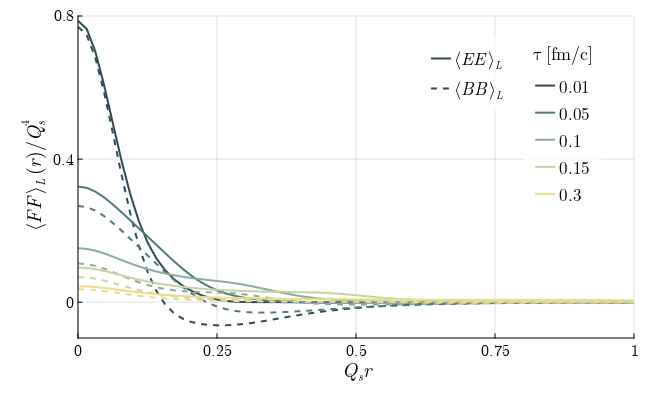

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000d7f5410, 3250.0, 2000.0)


In [24]:
using CairoMakie
using Interpolations
using ColorSchemes

starrynight = cgrad(:starrynight, 24, categorical = true)
colors = [starrynight[4], starrynight[8], starrynight[12], starrynight[16], starrynight[20]]

fig = Figure(resolution = (650, 400), font = "CMU Serif")
ax = Axis(fig[1,1], xlabel=L"Q_s r", ylabel=L"\langle FF\,\rangle_L\,(r)/Q_s^4",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=16, yticklabelsize=16,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5) 

units = res["E0"]^4/res["G"]^2
for (i, t) in enumerate(res["ts"])
        string_as_varname("line_el_"*string(i), lines!(ax, res["r"].*res["Qs"], res["EL"][string(t)].*units./res["Qs"]^4, linewidth = 2, color=colors[i]))
        string_as_varname("line_mag_"*string(i),lines!(ax, res["r"].*res["Qs"], res["BL"][string(t)].*units./res["Qs"]^4, linestyle="-", linewidth = 2, color=colors[i]))
end

xlims!(ax, 0, 1)
ylims!(ax, -0.1, 0.8)
ax.xticks = (0.25*(0:4), ["0", "0.25", "0.5", "0.75", "1"])
ax.yticks = (0.4*(0:2), ["0", "0.4", "0.8"])


axislegend(ax, [line_el_1, line_mag_1], [L"\langle EE\,\rangle_L", L"\langle BB\,\rangle_L"],  labelsize=18, 
    position = (0.75, 0.95), bgcolor = (:white, 0.7), framecolor = (:white, 0))
axislegend(ax, [line_el_1, line_el_2, line_el_3, line_el_4, line_el_5], 
    [L"0.01", L"0.05", L"0.1", L"0.15", L"0.3"], L"\tau\,\mathrm{[fm/c]}", titlesize=18,
    labelsize=17, position = (0.95,0.95),  bgcolor = (:white, 0.7), framecolor = (:white, 0))

display(fig)

save("corr_FF_L.png", fig, px_per_unit = 5.0) 

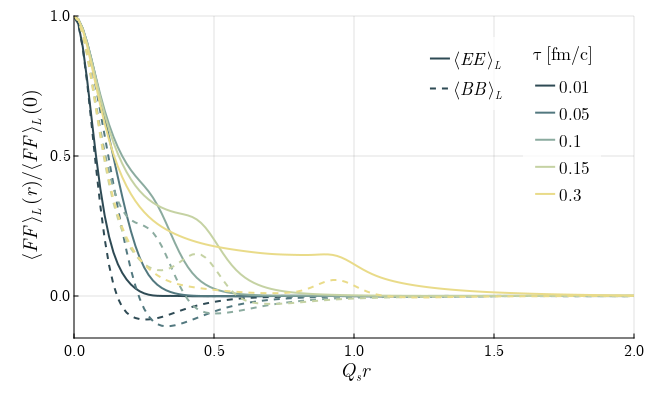

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000db33520, 3250.0, 2000.0)


In [35]:
using CairoMakie
using Interpolations
using ColorSchemes

starrynight = cgrad(:starrynight, 24, categorical = true)
colors = [starrynight[4], starrynight[8], starrynight[12], starrynight[16], starrynight[20]]

fig = Figure(resolution = (650, 400), font = "CMU Serif")
ax = Axis(fig[1,1], xlabel=L"Q_s r", ylabel=L"\langle FF\,\rangle_L\,(r)/\langle FF\,\rangle_L\,(0)",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=16, yticklabelsize=16,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5) 

for (i, t) in enumerate(res["ts"])
        string_as_varname("line_el_"*string(i), lines!(ax, res["r"].*res["Qs"], res["EL"][string(t)]/res["EL"][string(t)][1], linewidth = 2, color=colors[i]))
        string_as_varname("line_mag_"*string(i),lines!(ax, res["r"].*res["Qs"], res["BL"][string(t)]/res["BL"][string(t)][1], linestyle="-", linewidth = 2, color=colors[i]))
end

xlims!(ax, 0, 2)
ylims!(ax, -0.15, 1)
# ax.xticks = (0.25*(0:4), ["0", "0.25", "0.5", "0.75", "1"])
# ax.yticks = (40*(0:2), ["0", "40", "80"])


axislegend(ax, [line_el_1, line_mag_1], [L"\langle EE\,\rangle_L", L"\langle BB\,\rangle_L"],  labelsize=18, 
    position = (0.75, 0.95), bgcolor = (:white, 0.7), framecolor = (:white, 0))
axislegend(ax, [line_el_1, line_el_2, line_el_3, line_el_4, line_el_5], 
    [L"0.01", L"0.05", L"0.1", L"0.15", L"0.3"], L"\tau\,\mathrm{[fm/c]}", titlesize=18,
    labelsize=17, position = (0.95,0.95),  bgcolor = (:white, 0.7), framecolor = (:white, 0))

display(fig)

save("corr_FF_L_normalized.png", fig, px_per_unit = 5.0) 